# Download Data

In [ ]:
from google.colab import files

# Install Kaggle library
!pip install -q kaggle
# Upload kaggle API key file
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
#download dataset
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset
!unzip '/content/semantic-drone-dataset.zip'

# Pre Processing

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install segmentation-models-pytorch
!pip install torchsummary
from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 51kB 1.5MB/s 
     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=6bc57589fdca6360e2995ef28e9f349d8818ec46f7935050b71cadfdf4029b55
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=163c204298cdb7afdc11e4ee0e7990dad181e38fb1b08ba2492c23215297a568
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


# Preprocessing

In [3]:
IMAGE_PATH = '/content/semantic_drone_dataset/original_images/'
MASK_PATH = '/content/semantic_drone_dataset/label_images_semantic/'


n_classes = 23 
# tree, gras, other vegetation, dirt, gravel, rocks, water, 
#paved area, pool, person, dog, car, bicycle, roof, wall, fence, 
#fence-pole, window, door, obstacle

#read file id in directory
name = []
for dirname, _, filenames in os.walk(IMAGE_PATH):
    for filename in filenames:
        name.append(filename.split('.')[0])

df = pd.DataFrame({'id': name}, index = np.arange(0, len(name)))
print('Number of Data: ', len(df))

#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Number of Data:  400
Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)
Uniqe Pixel Value from mask [ 0  1  4  6  8 15 17 18 19 22]


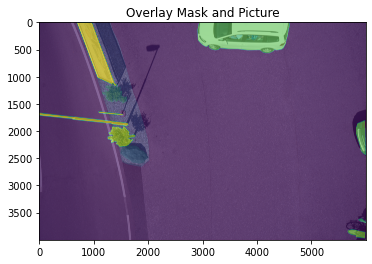

In [4]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)
print('Uniqe Pixel Value from mask', np.unique(np.asarray(mask)))

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Overlay Mask and Picture')
plt.show()

## Costum datasets

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
class Drone_data(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=True, shuffle=True):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        """
        get item per index
        """
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        #transfrom different for image and mask
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):
        """
        split image into smaler patches 
        """
        #for image
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) #tile overlap 50pixel
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) #change to total tile
        img_patches = img_patches.permute(1,0,2,3)#place the tiles number in the 0 index
        
        #for mask
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [7]:
def calc_resize_ration(re_ration_to_depth=10, unet_depth=5, width=6000, height=4000):
    width_to_height_rat = width/height
    unet_ratio = 2**unet_depth

    wid = unet_ratio * re_ration_to_depth * width_to_height_rat
    heig = unet_ratio * re_ration_to_depth 
    
    print('After resize with the same ration:')
    print(f' height:width = {heig, wid}')
    print(f' size after encoding: {heig/(2**unet_depth), wid/(2**unet_depth)}')

In [ ]:
calc_resize_ration(10)

After resize with the same ration:
 height:width = (320, 480.0)
 size after encoding: (10.0, 15.0)


In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

#augmentation
# 1. (448, 672)
t_train = A.Compose([A.Resize(320, 480, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(320, 480, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

t_test = A.Resize(1024, 1536, interpolation=cv2.INTER_NEAREST)

#datasets
train_set = Drone_data(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = Drone_data(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)
test_set = Drone_data(IMAGE_PATH, MASK_PATH, X_test, mean, std, transform=t_test, patch=False)

#dataloader
batch_size= 4 #4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

In [ ]:
# img = cv2.imread(IMAGE_PATH + df['id'][200] + '.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# t = A.RandomBrightnessContrast((-0.5,0.5),(-0.5,0.5),always_apply=True)
# aug = t(image=img, mask=None)
# plt.imshow(aug['image'])

# Model

## Deeplabv3

In [ ]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
#model.to(device)
#model.train()
model.classifier[4] = nn.Conv2d(in_channels=256,
                                out_channels=23,
                                kernel_size=1,
                                stride=1
                                )


model.aux_classifier[4] = nn.Conv2d(in_channels=256,
                                out_channels=23,
                                kernel_size=1,
                                stride=1
                                )
model.to(device)
model.train()

## U-Net

In [16]:
model = smp.Unet('efficientnet-b3', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
model.to(device)
model.train()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        

In [ ]:
#summary(model.cpu(), (3, 320, 480), device='cpu')

# Training

## Costum Metrics and Loss

In [12]:
# def IoU_score(inputs, targets, num_classes=23, smooth=1e-5):
#     with torch.no_grad():
#         #soft = nn.Softmax2d()
#         inputs = F.softmax(inputs, dim=1) #convert into probabilites 0-1
#         targets = F.one_hot(targets, num_classes = n_classes).permute(0,3,1,2).contiguous()#convert target into one-hot


#         inputs = inputs.contiguous().view(-1)
#         targets = targets.view(-1)

#         #intersection is equivalent to True Positive count
#         #union is the mutually inclusive area of all labels & predictions 
#         intersection = (inputs * targets).sum()
#         total = (inputs + targets).sum()
#         union = total - intersection 

#         IoU = (intersection + smooth)/(union + smooth)
        
#         return IoU.item()

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    """
    calculate IoU perclass pixel
    input       : pre_mask = ouput from model as prediction mask
    mask        : ground truth mask
    smooth      : for non zero devision
    n_classes   : number of class label

    return : mean over all classes
    """
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)
    
def iou(pred, target, n_classes = n_classes):
    with torch.no_grad():
        ious = []
        pred_mask = F.softmax(pred, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)

        pred = pred_mask.contiguous().view(-1)
        target = target.contiguous().view(-1)

        # Ignore IoU for background class ("0")
        for cls in range(0, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
            pred_inds = pred == cls
            target_inds = target == cls
            intersection = (pred_inds[target_inds]).long().sum()  # Cast to long to prevent overflows
            union = pred_inds.long().sum() + target_inds.long().sum() - intersection
            if union == 0:
                ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
            else:
                ious.append(float(intersection) / float(max(union, 1)))
        return np.nanmean(ious)
class DiceLoss(nn.Module):
    def __init__(self, n_class, smooth = 1e-10):
        super(DiceLoss, self).__init__()
        self.n_classes = n_class
        self.smooth = smooth

    def forward(self, inputs, targets, smooth=1e-5):

        #preparation
        inputs = F.softmax(inputs, dim=1) #convert into probabilites 0-1
        labels = F.one_hot(targets, num_classes = self.n_classes).permute(0,3,1,2).contiguous()#convert target into one-hot
        
        #flatten label and prediction tensors
        inputs = inputs.contiguous().view(-1)
        targets = labels.view(-1)

        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)  
        
        return 1. - dice

In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler=None, patch=False):
    """
    training loop to update the weights and bias
    epoch : number for epoch
    model : model architecture for training
    scheduler : if using sceduler

    return: history from training loss and evaluation metrics
    """
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; 
    train_iou = [];
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #loss2 = criterion(output['aux'], mask)

            #loss = loss1 + 0.04 * loss2
            #score
            iou_score += iou(output, mask)
            #backward
            loss.backward() 
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            if scheduler is not None:
                lrs.append(get_lr(optimizer))
                scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            total_train = 0
            correct_train = 0
            val_iou_score = 0
            val_dice_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #score
                    val_iou_score +=  iou(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, '/content/drive/My Drive/Colab Notebooks/models/efficient-b3_drone_{:.3f}.pt'.format((test_loss/len(val_loader))))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
        
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)), 
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou, 
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

## Looping

In [18]:
max_lr = 1e-3 #1e-4
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)


Loss Decreasing.. inf >> 2.883 
Epoch:1/30.. Train Loss: 3.161.. Val Loss: 2.883.. Train mIoU:0.019.. Val mIoU: 0.031.. Time: 4.45m



Loss Decreasing.. 2.883 >> 1.994 
Epoch:2/30.. Train Loss: 2.618.. Val Loss: 1.994.. Train mIoU:0.057.. Val mIoU: 0.081.. Time: 4.45m



Loss Decreasing.. 1.994 >> 1.251 
Epoch:3/30.. Train Loss: 1.830.. Val Loss: 1.251.. Train mIoU:0.089.. Val mIoU: 0.117.. Time: 4.44m



Loss Decreasing.. 1.251 >> 1.040 
saving model...
Epoch:4/30.. Train Loss: 1.379.. Val Loss: 1.040.. Train mIoU:0.124.. Val mIoU: 0.138.. Time: 4.44m



Loss Decreasing.. 1.040 >> 0.997 
Epoch:5/30.. Train Loss: 1.276.. Val Loss: 0.997.. Train mIoU:0.137.. Val mIoU: 0.151.. Time: 4.42m



Loss Decreasing.. 0.997 >> 0.947 
Epoch:6/30.. Train Loss: 1.128.. Val Loss: 0.947.. Train mIoU:0.163.. Val mIoU: 0.162.. Time: 4.43m



Loss Not Decrease for 1 time
Epoch:7/30.. Train Loss: 1.111.. Val Loss: 1.082.. Train mIoU:0.173.. Val mIoU: 0.151.. Time: 4.42m



Loss Decreasing.. 1.082 >> 0.943 
Epoch:8/30.. Train Loss: 1.001.. Val Loss: 0.943.. Train mIoU:0.191.. Val mIoU: 0.172.. Time: 4.46m



Loss Decreasing.. 0.943 >> 0.911 
Epoch:9/30.. Train Loss: 0.943.. Val Loss: 0.911.. Train mIoU:0.199.. Val mIoU: 0.185.. Time: 4.44m



Loss Not Decrease for 2 time
Epoch:10/30.. Train Loss: 0.906.. Val Loss: 0.912.. Train mIoU:0.212.. Val mIoU: 0.184.. Time: 4.42m



Loss Decreasing.. 0.912 >> 0.779 
saving model...
Epoch:11/30.. Train Loss: 0.869.. Val Loss: 0.779.. Train mIoU:0.220.. Val mIoU: 0.201.. Time: 4.43m



Loss Decreasing.. 0.779 >> 0.696 
Epoch:12/30.. Train Loss: 0.804.. Val Loss: 0.696.. Train mIoU:0.235.. Val mIoU: 0.224.. Time: 4.41m



Loss Decreasing.. 0.696 >> 0.679 
Epoch:13/30.. Train Loss: 0.739.. Val Loss: 0.679.. Train mIoU:0.248.. Val mIoU: 0.246.. Time: 4.38m



Loss Not Decrease for 3 time
Epoch:14/30.. Train Loss: 0.741.. Val Loss: 0.794.. Train mIoU:0.251.. Val mIoU: 0.210.. Time: 4.39m



Loss Decreasing.. 0.794 >> 0.748 
Epoch:15/30.. Train Loss: 0.739.. Val Loss: 0.748.. Train mIoU:0.253.. Val mIoU: 0.225.. Time: 4.40m



Loss Decreasing.. 0.748 >> 0.662 
Epoch:16/30.. Train Loss: 0.707.. Val Loss: 0.662.. Train mIoU:0.262.. Val mIoU: 0.242.. Time: 4.41m



Loss Decreasing.. 0.662 >> 0.571 
saving model...
Epoch:17/30.. Train Loss: 0.648.. Val Loss: 0.571.. Train mIoU:0.287.. Val mIoU: 0.299.. Time: 4.39m



Loss Decreasing.. 0.571 >> 0.558 
Epoch:18/30.. Train Loss: 0.609.. Val Loss: 0.558.. Train mIoU:0.304.. Val mIoU: 0.294.. Time: 4.38m



Loss Decreasing.. 0.558 >> 0.554 
Epoch:19/30.. Train Loss: 0.580.. Val Loss: 0.554.. Train mIoU:0.312.. Val mIoU: 0.317.. Time: 4.40m



Loss Not Decrease for 4 time
Epoch:20/30.. Train Loss: 0.570.. Val Loss: 0.576.. Train mIoU:0.316.. Val mIoU: 0.310.. Time: 4.40m



Loss Decreasing.. 0.576 >> 0.517 
Epoch:21/30.. Train Loss: 0.535.. Val Loss: 0.517.. Train mIoU:0.327.. Val mIoU: 0.333.. Time: 4.39m



Loss Decreasing.. 0.517 >> 0.513 
Epoch:22/30.. Train Loss: 0.520.. Val Loss: 0.513.. Train mIoU:0.339.. Val mIoU: 0.345.. Time: 4.38m



Loss Decreasing.. 0.513 >> 0.506 
saving model...
Epoch:23/30.. Train Loss: 0.525.. Val Loss: 0.506.. Train mIoU:0.345.. Val mIoU: 0.351.. Time: 4.38m



Loss Decreasing.. 0.506 >> 0.482 
Epoch:24/30.. Train Loss: 0.486.. Val Loss: 0.482.. Train mIoU:0.355.. Val mIoU: 0.365.. Time: 4.38m



Loss Decreasing.. 0.482 >> 0.468 
Epoch:25/30.. Train Loss: 0.478.. Val Loss: 0.468.. Train mIoU:0.357.. Val mIoU: 0.349.. Time: 4.40m



Loss Decreasing.. 0.468 >> 0.460 
Epoch:26/30.. Train Loss: 0.476.. Val Loss: 0.460.. Train mIoU:0.366.. Val mIoU: 0.359.. Time: 4.40m



Loss Not Decrease for 5 time
Epoch:27/30.. Train Loss: 0.462.. Val Loss: 0.470.. Train mIoU:0.369.. Val mIoU: 0.375.. Time: 4.41m



Loss Not Decrease for 6 time
Epoch:28/30.. Train Loss: 0.473.. Val Loss: 0.473.. Train mIoU:0.362.. Val mIoU: 0.361.. Time: 4.41m



Loss Decreasing.. 0.473 >> 0.473 
Epoch:29/30.. Train Loss: 0.464.. Val Loss: 0.473.. Train mIoU:0.363.. Val mIoU: 0.358.. Time: 4.38m



Loss Decreasing.. 0.473 >> 0.464 
saving model...
Epoch:30/30.. Train Loss: 0.464.. Val Loss: 0.464.. Train mIoU:0.369.. Val mIoU: 0.365.. Time: 4.37m
Total time: 132.27 m


In [19]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

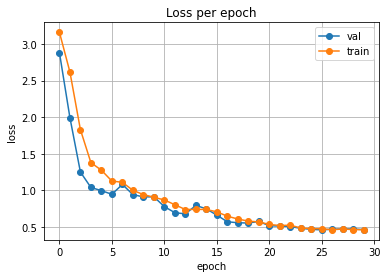

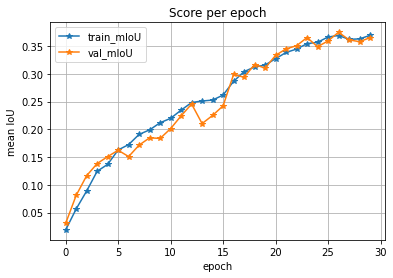

In [20]:
plot_loss(history)
plot_score(history)

In [ ]:
#save model
torch.save(model, '/content/drive/My Drive/Colab Notebooks/models/deeplabv3_drone-30fullepoch.pt')

# Evaluation

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/models/deeplabv3_drone-30fullepoch.pt')
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [21]:
def predict_image_mask(model, image, mask):
    model.eval()
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = iou(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return 
        
unormal = UnNormalize(mean, std)

0.38256587186957275
CPU times: user 1.09 s, sys: 265 ms, total: 1.36 s
Wall time: 1.34 s


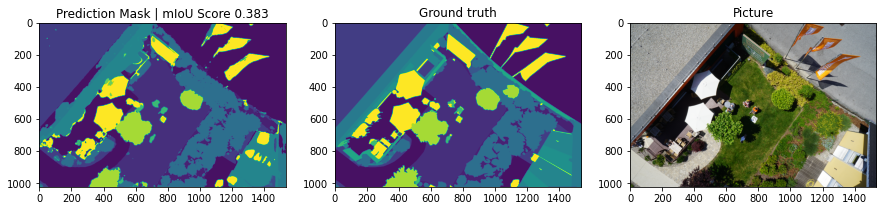

In [36]:
%%time
image, mask = test_set[17]
pred_mask, score = predict_image_mask(model, image,mask)

print(score)
unormal(image)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,10))
ax1.imshow(pred_mask)
ax1.set_title('Prediction Mask | mIoU Score {:.3f}'.format(score))
ax2.imshow(mask)
ax2.set_title('Ground truth')
ax3.imshow(image.permute(1,2,0))
ax3.set_title('Picture');
plt.show

In [37]:
image = image.to(device)
output = model(image.unsqueeze(0))

output = torch.argmax(output, dim=1)
pre = output.view(-1).long().detach().cpu().numpy()
mask = mask.view(-1).long().numpy()

jaccard_score(mask, pre, average='micro')

0.2962746394862254